In [15]:
from datetime import datetime as dt

base_dir = "./data/testing_landcover_model"
start_date = dt(2022, 1, 1)
end_date = dt(2022, 3, 1)
bbox_sb = [-119.709622, 34.395196, -119.596430, 34.451896]

cloud_mask_model_path = "./cloud_detection_model_resnet18_dice_20230327.pth"

bbox = bbox_sb # change to bbox as necessary

In [16]:
from common.utilities.download import get_collection, get_processed_composite

collection_path = f'{base_dir}/collection.json'
collection = get_collection(start_date, end_date, bbox, collection_path, max_cloud_cover=20, max_tile_count=4, min_tile_count=3)
composite_path = get_processed_composite(collection, bbox, base_dir, cloud_mask_model_path)


./data/testing_landcover_model/collection.json: {'GD': 4, 'KU': 4}


In [17]:

model_path = "./landcover_classification_model_resnet18_dice_20230405.pth"


In [18]:
import numpy as np
import rasterio
import torch


with rasterio.open(composite_path) as src:
    og_image = src.read(masked=True)
    og_image = og_image.filled(-1.0)
    saved_shape = og_image.shape

height_pad = 32 - (og_image.shape[1] % 32)
width_pad = 32 - (og_image.shape[2] % 32)
padded_image = np.pad(og_image, ((0, 0), (0, height_pad), (0, width_pad)), mode='reflect')

image = np.expand_dims(padded_image, 0)     
image = torch.tensor(image)

model = torch.load(model_path)

prediction = model.predict(image)

probabilities = torch.sigmoid(prediction)
prediction = torch.argmax(probabilities, dim=1)

prediction = (prediction.squeeze().cpu().numpy().round())
prediction = np.ma.array(prediction, mask=(prediction==0))

og_image = og_image[:, :saved_shape[1], :saved_shape[2]]
prediction = prediction[:saved_shape[1], :saved_shape[2]]


print('done')

done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction')

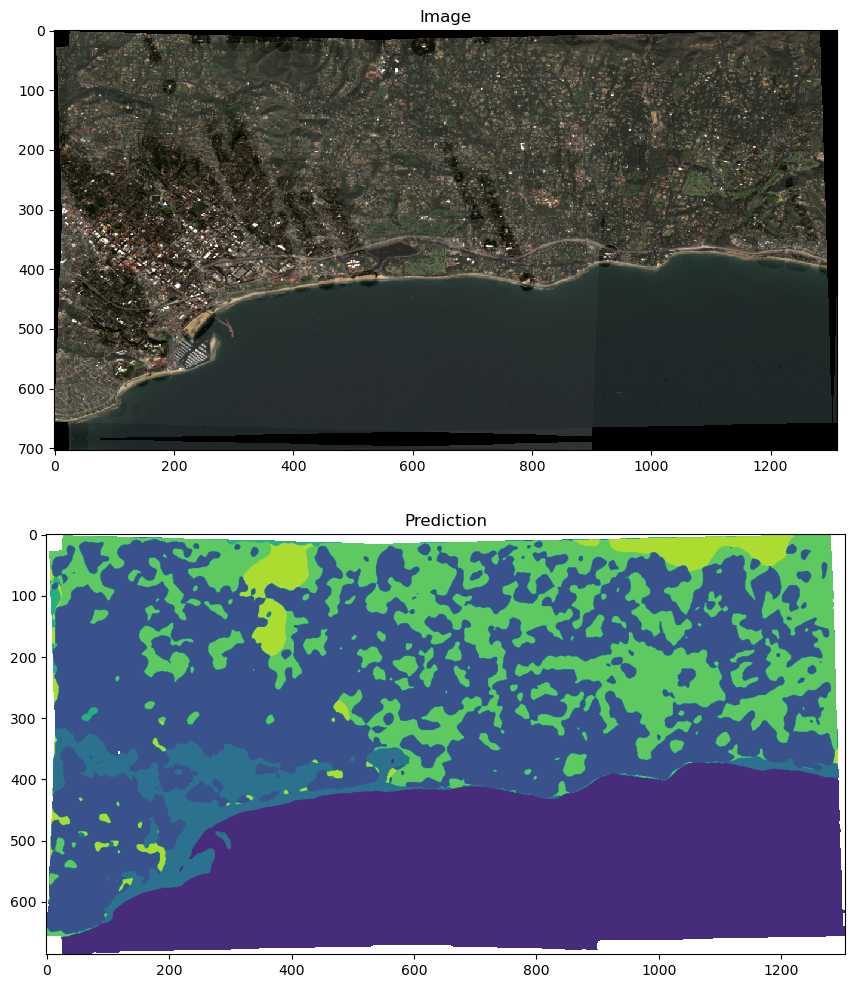

In [19]:
import matplotlib.pyplot as plt

from common.utilities.visualization import plot_bands


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

plot_bands(padded_image, bands=[2, 1, 0], ax=ax1, transpose=True)
ax1.set_title('Image')

ax2.imshow(prediction, vmin=0, vmax=8)
ax2.set_title('Prediction')

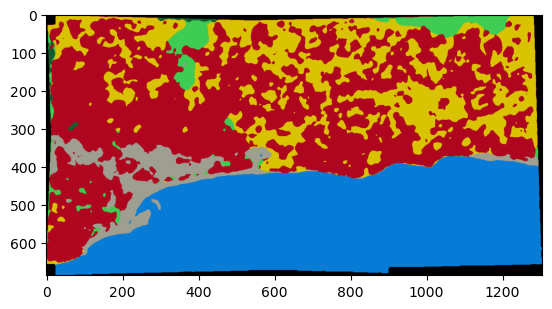

In [20]:
from common.utilities.imagery import write_array_to_tif

colors = {
    1: (6, 124, 214),   # water
    2: (176, 5, 31),    # bare artificial
    3: (158, 158, 145), # bare natural
    4: (205, 221, 247), # snow/ice
    5: (19, 92, 46),    # woody
    6: (217, 195, 0),   # cultivated
    7: (63, 204, 82),   # semi natural vegetation
}

statistics = {}
colored_landcover = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
for value, color in colors.items():
    mask = (prediction == value)
    colored_landcover[mask] = color
    statistics[value] = {
        'total_area_m2': np.sum(mask) * 100
    }
    
plt.imshow(colored_landcover, vmin=1, vmax=8)
    
prediction_color_path = f'{base_dir}/prediction_color.tif'
write_array_to_tif(prediction, prediction_color_path, bbox_sb, dtype=np.uint8, epsg=4326, nodata=255)